In [1]:
# All libraries
import jetset
print('tested on jetset',jetset.__version__)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jetset.data_loader import Data
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.jet_model import Jet
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.sed_shaper import  SEDShape
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import fit_SED
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.mcmc import McmcSampler

tested on jetset 1.2.2


---> excluding  data_set/s ['-1']
filter -1 37
current datasets
dataset 0.0
---> data sets left after filtering None
---> data len after filtering=37

***  binning data  ***
---> N bins= 113
---> bin_widht= 0.15

---> setting  UL
---> Settin  UL for val [0, 0, 2.94e-13, 7.22e-14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.29e-12, 0, 0, 0, 1.38e-13, 5.38e-13, 7.93e-13]


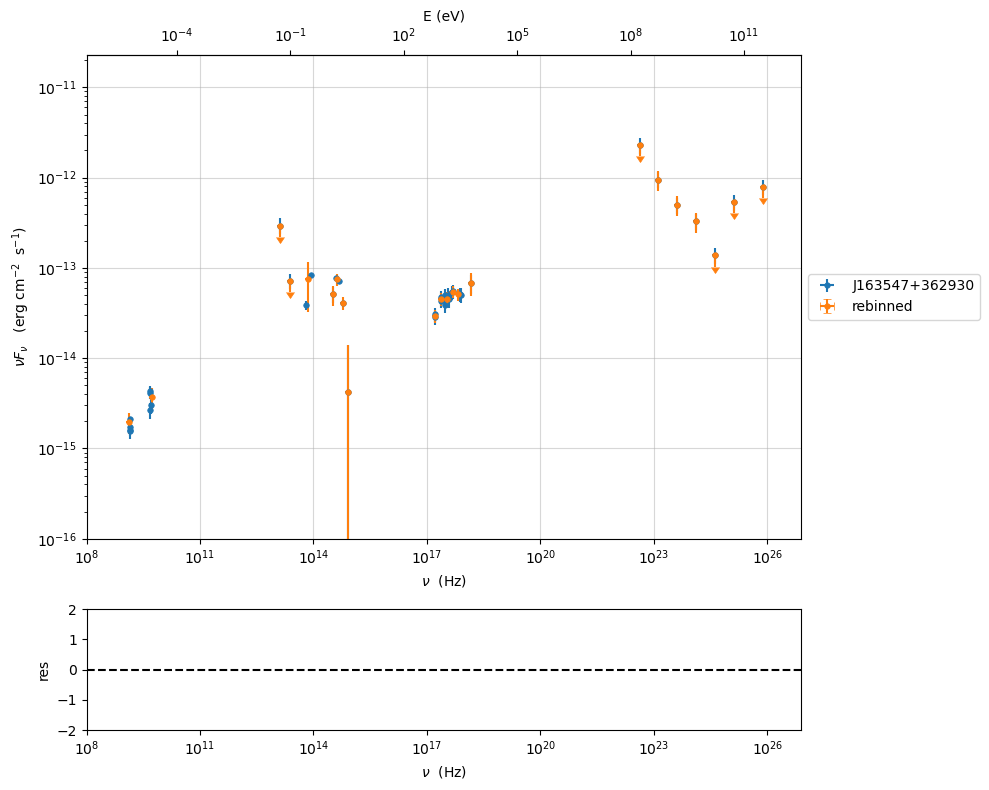

In [2]:
d=np.genfromtxt('sed2.txt')
data=Data(n_rows=d.shape[0])
data.set_field('x',d[:,0])
data.set_field('y',d[:,1])
data.set_field('dy',value=d[:,2])
#data.table[22]['UL']=True
#data.table[23]['UL']=True
data.set_meta_data('z',3.647763)
data.set_meta_data('UL_CL', 0.95)
data.set_meta_data('restframe','obs')
data.set_meta_data('data_scale','lin-lin')
data.set_meta_data('obj_name','J163547+362930')

sed_data=ObsData(data_table=data)
myPlot=sed_data.plot_sed()
sed_data.filter_data_set('-1',exclude=True)
sed_data.group_data(bin_width=.15)
sed_data.add_systematics(0.15,[10.**6,10.**29])
sed_data.set_UL([0,0,2.94E-13,7.22e-14,0,0,0,0,
                 0,0,0,0,0,0,0,2.29e-12,0,0,0,
                 1.38e-13,5.38e-13,7.93e-13])
myPlot.add_data_plot(sed_data,label='rebinned')
myPlot.setlim(y_min=1E-16,x_min=1E8)

#sed_data.save('J163547_data.pkl')


*** evaluating spectral indices for data ***
!Warning, no covariance matrix produced
!Warning, no covariance matrix produced
!Warning, no covariance matrix produced



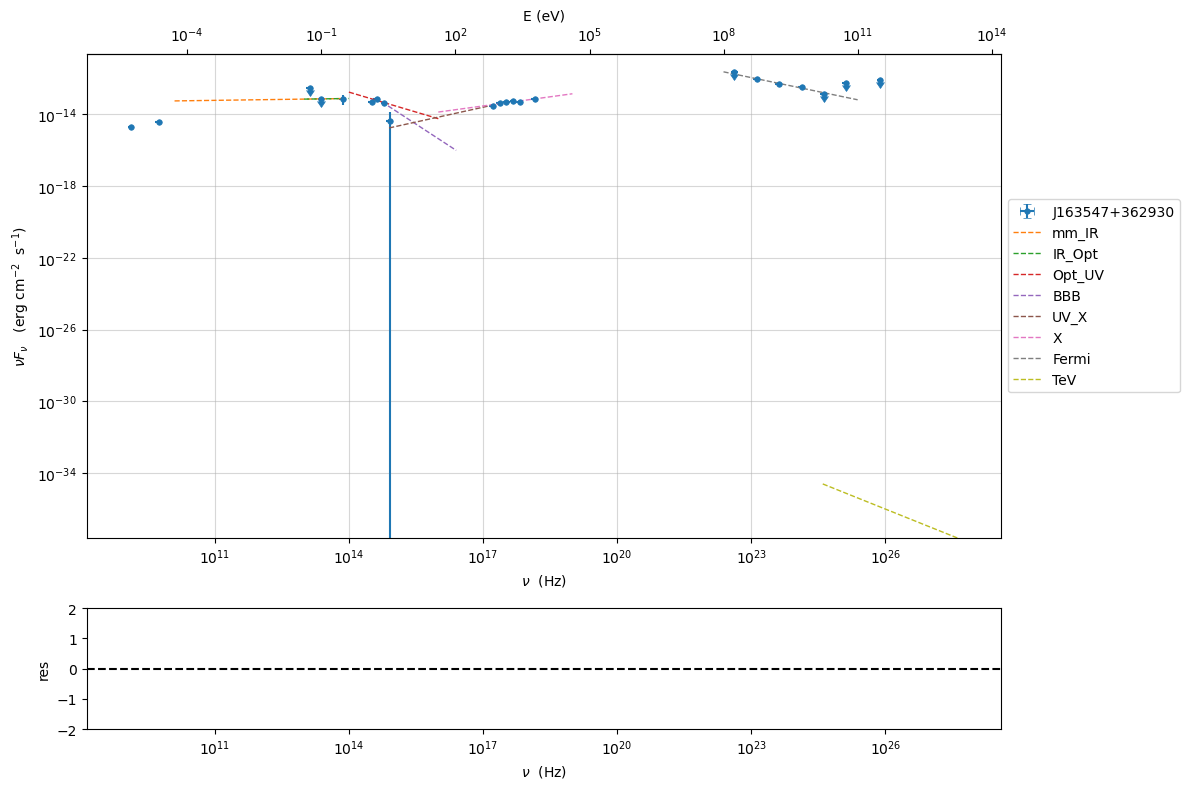

In [3]:
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [9, 16]
--> class:  LSP

!Warning, no covariance matrix produced
--> class:  LSP




---> sync       nu_p=+1.313274e+01 (err=+8.246327e-01)  nuFnu_p=-1.334615e+01 (err=+1.826663e-01) curv.=-8.834406e-02 (err=+4.140533e-02)


*** Log-Polynomial fitting of the IC component ***
---> fit range: [16, 26]
---> LogCubic fit




---> IC         nu_p=+2.211356e+01 (err=+1.622933e-01)  nuFnu_p=-1.188857e+01 (err=+1.207393e-01) curv.=-1.357163e-01 (err=+2.247093e-02)



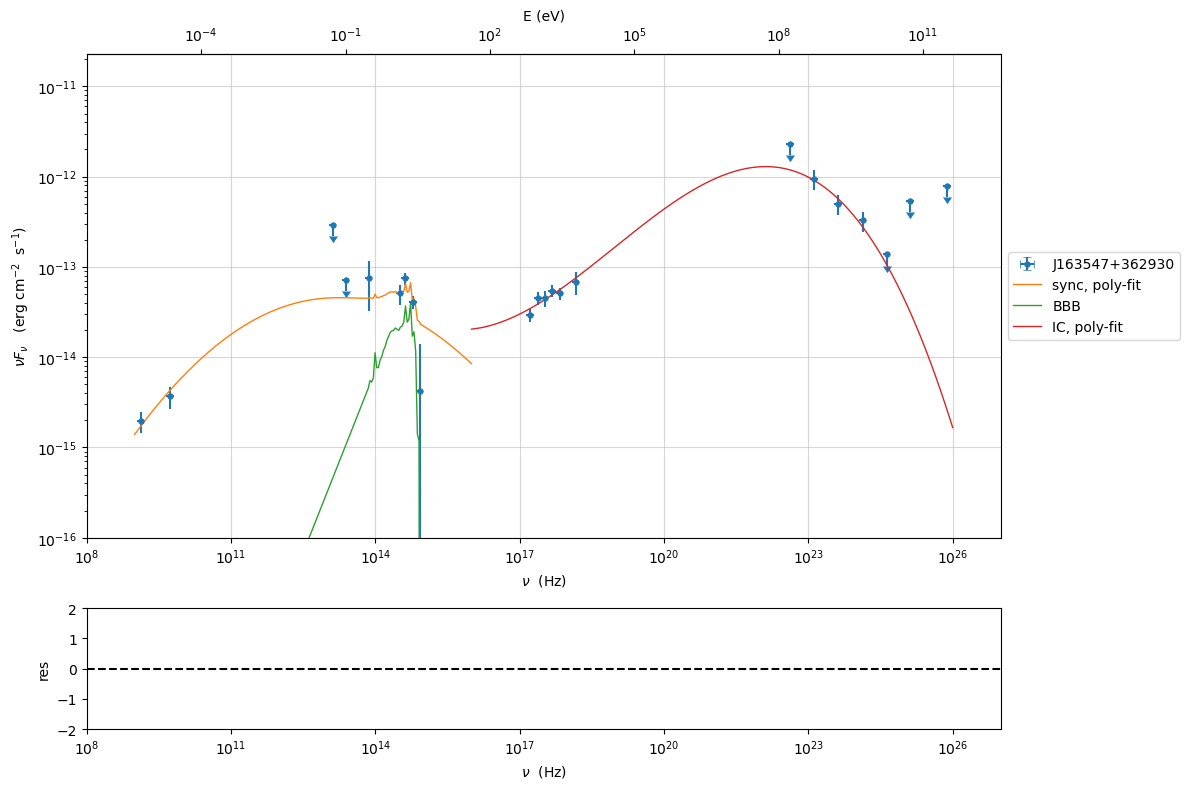

In [6]:
mm,best_fit=my_shape.sync_fit(check_BBB_template=True,
                              check_host_gal_template=False,
                              use_log_par=True,
                              Ep_start=None,
                              minimizer='lsb',
                              silent=True,
                              fit_range=[9,16])
my_shape.IC_fit(fit_range=[16,26],minimizer='minuit', silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-16)


***  constrains parameters from observable ***





19.097330879509727


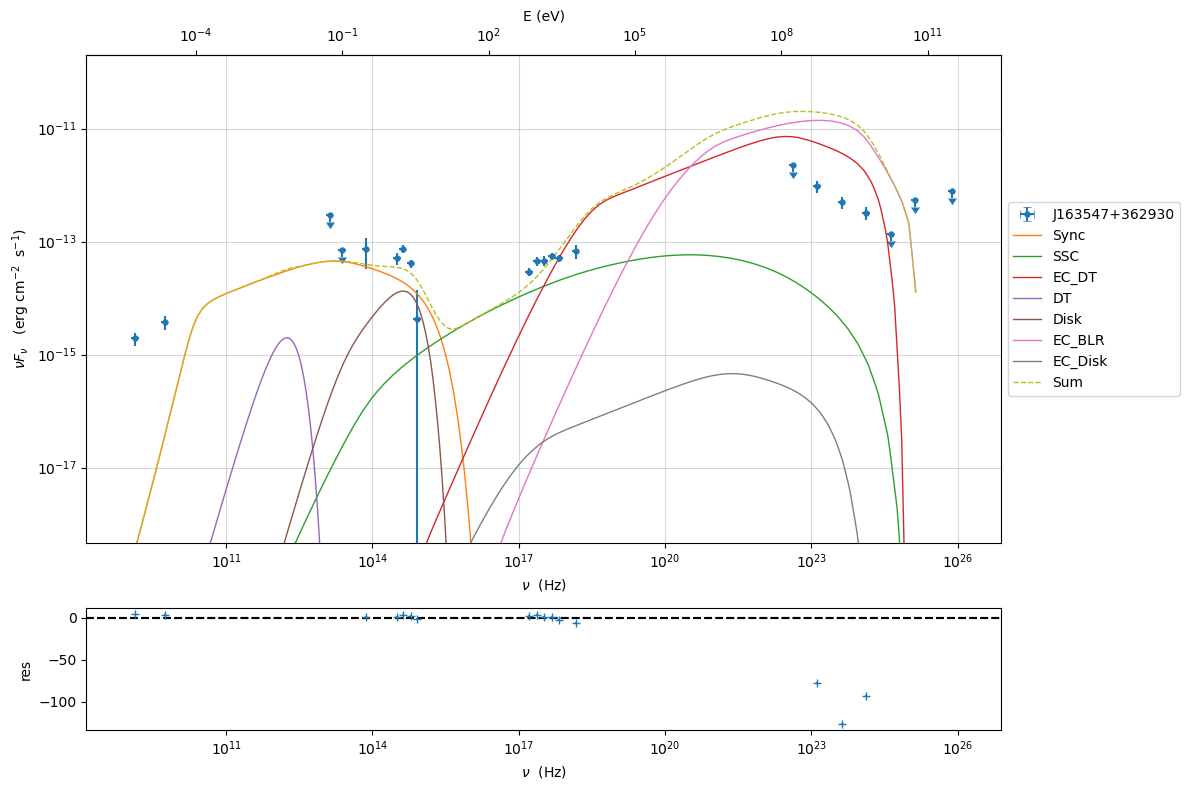

In [18]:
sed_obspar=ObsConstrain(theta=3,
                        bulk_factor=18.5,
                        B_range=[0.02,0.08],
                        distr_e='bkn',
                        t_var_sec=7*86400,
                        nu_cut_IR=1E9,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_EC_model(electron_distribution_log_values=False,
                                             EC_componets_list=['EC_DT','EC_BLR','EC_Disk'],
                                             R_H=1.5E18,
                                             disk_type='MultiBB',
                                             silent=True)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data)
p.add_residual_plot(prefit_jet,sed_data)
p.save('prefit.png')
print(prefit_jet.get_beaming())
prefit_jet.save_model('PrePre.pkl')

## External_field_transf -> Disk

==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5


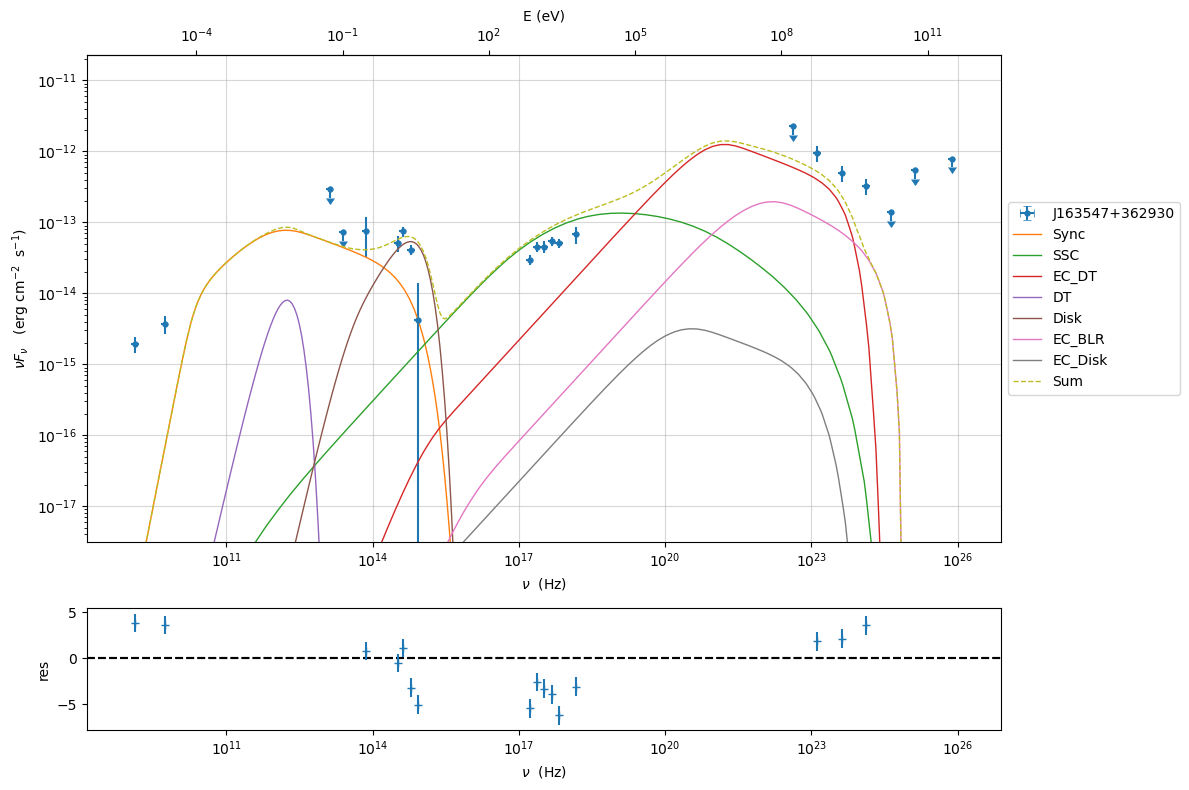

In [2]:
sed_data = ObsData.load('J163547_data.pkl')
prefit_jet=Jet.load_model('PrePre.pkl')
prefit_jet.set_external_field_transf('disk')
prefit_jet.add_user_par(name='theta_open',val=3,units='deg')
prefit_jet.make_dependent_par(par='R', depends_on=['R_H','theta_open'],
                              par_expr='np.tan((theta_open*np.pi/180))*R_H')

prefit_jet.make_dependent_par(par='R_BLR_in', depends_on=['L_Disk'], par_expr='3E17*(L_Disk/1E46)**0.5')
prefit_jet.make_dependent_par(par='R_BLR_out', depends_on=['R_BLR_in'], par_expr='R_BLR_in*1.1')
prefit_jet.make_dependent_par(par='R_DT', depends_on=['L_Disk'], par_expr='2E19*(L_Disk/1E46)**0.5')

prefit_jet.set_par('L_Disk',val=1.381e46)
prefit_jet.set_par('gmin',val=1.00)
prefit_jet.set_par('gmax',val=2.00e4)
prefit_jet.set_par('gamma_break',val=1.00e3)
prefit_jet.set_par('N',val=1.50e3)
prefit_jet.set_par('p',val=1.5)
prefit_jet.eval()
#prefit_jet.show_model()
p=prefit_jet.plot_model(sed_data=sed_data, frame='obs')
p.add_residual_plot(prefit_jet,sed_data)
p.save('prefit2.png')

filtering data in fit range = [1.000000e+08,1.000000e+30]
data length 22

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=3.64829e+01

fit run: 1
- old chisq=3.64829e+01


0it [00:00, ?it/s]

- best chisq=3.64796e+01

fit run: 2
- old chisq=3.64796e+01


0it [00:00, ?it/s]

- best chisq=3.64760e+01

-------------------------------------------------------------------------
Fit report

Model: Sum



converged=True
calls=1050
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.48                      │             Nfcn = 1050              │
│ EDM = 0.0295 (Goal: 0.0002)      │           time = 304.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │  1.43e3   │  0.05e3   │            │            │   400   │  2000   │       │
│ 1 │ par_1  │    893    │    34     │            │            │   800   │  2000   │       │
│ 2 │ par_2  │   1.501   │   0.007   │            │            │  1.35   │   1.6   │       │
│ 3 │ par_3  │   3.27    │   0.05    │            │            │    3    │   3.8   │       │
│ 4 │ par_4  │   0.9e3   │   0.8e3   │            │            │   100   │  1000   │       │
│ 5 │ par_5  │   10.1    │    1.4    │            │            │    3    │   15    │       │
│ 6 │ par_6  │   0.8e3   │   0.9e3   │            │            │   50    │  1000   │       │
│ 7 │ par_7  │  0.99e9   │  0.04e9   │            │            │  5e+08  │  2e+09  │       │
│ 8 │ par_8  │13.8172e45 │ 0.0013e45 │            │            │  1e+46  │  5e+46  │       │
│ 9 │ par_9  │1.50004e18 │0.00024e18 │            │            │  5e+17  │  3e+18  │       │
│ 10│ par_10 │  0.0505   │  0.0021   │            │            │  0.01   │   0.1   │       │
│ 11│ par_11 │    20     │    11     │            │            │   10    │   25    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9    par_10    par_11 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  par_0 │  2.38e+03      -329      0.08      0.27  1.34e+03     -1.32 -1.08e+03 -2.65e+07  2.14e+42 -3.89e+14   -0.0216      13.5 │
│  par_1 │      -329  1.18e+03    0.0501      0.33      -302   -0.0953 -1.33e+03  -1.3e+07 -2.57e+42  5.08e+14   -0.0123     -13.5 │
│  par_2 │      0.08    0.0501  5.43e-05 -4.31e-05    -0.182    0.0002     0.173     4e+03 -2.55e+38  4.56e+10  3.21e-06  -0.00165 │
│  par_3 │      0.27      0.33 -4.31e-05   0.00283      6.92  -0.00533      2.89 -2.59e+04  2.17e+40 -4.15e+12  6.99e-06    0.0859 │
│  par_4 │  1.34e+03      -302    -0.182      6.92  4.34e+05      6.04 -2.71e+04 -6.01e+07   8.2e+44 -1.53e+17     0.143      -868 │
│  par_5 │     -1.32   -0.0953    0.0002  -0.00533      6.04      1.84     -11.2 -9.54e+06  5.57e+39 -5.37e+11  0.000161   -0.0756 │
│  par_6 │ -1.08e+03 -1.33e+03     0.173      2.89 -2.71e+04     -11.2  8.26e+05 -9.52e+07 -8.52e+43  1.71e+16   -0.0152      -337 │
│  par_7 │ -2.65e+07  -1.3e+07     4e+03 -2.59e+04 -6.01e+07 -9.54e+06 -9.52e+07  2.02e+15 -1.33e+47 -6.49e+19       169   5.8e+05 │
│  par_8 │  2.14e+42 -2.57e+42 -2.55e+38  2.17e+40   8.2e+44  5.57e+39 -8.52e+43 -1.33e+47  1.71e+84 -3.14e+56  3.29e+38 -2.87e+42 │
│  p

dof=10
chisq=36.475973, chisq/red=3.647597 null hypothesis sig=0.000070

stats without the UL
dof  UL=4
chisq=36.368844, chisq/red=9.092211 null hypothesis sig=0.000000


best fit pars


-------------------------------------------------------------------------



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: Standard SSD  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  

electrons distribution:
 type: bkn  
 gamma energy grid size:  201
 gmin grid : 1.000000e+00
 gmax grid : 2.000000e+04
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e-01

accretion disk:
 disk Type: MultiBB
 L disk: 1.381718e+46 (erg/s)
 T di

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


19.09938857733447


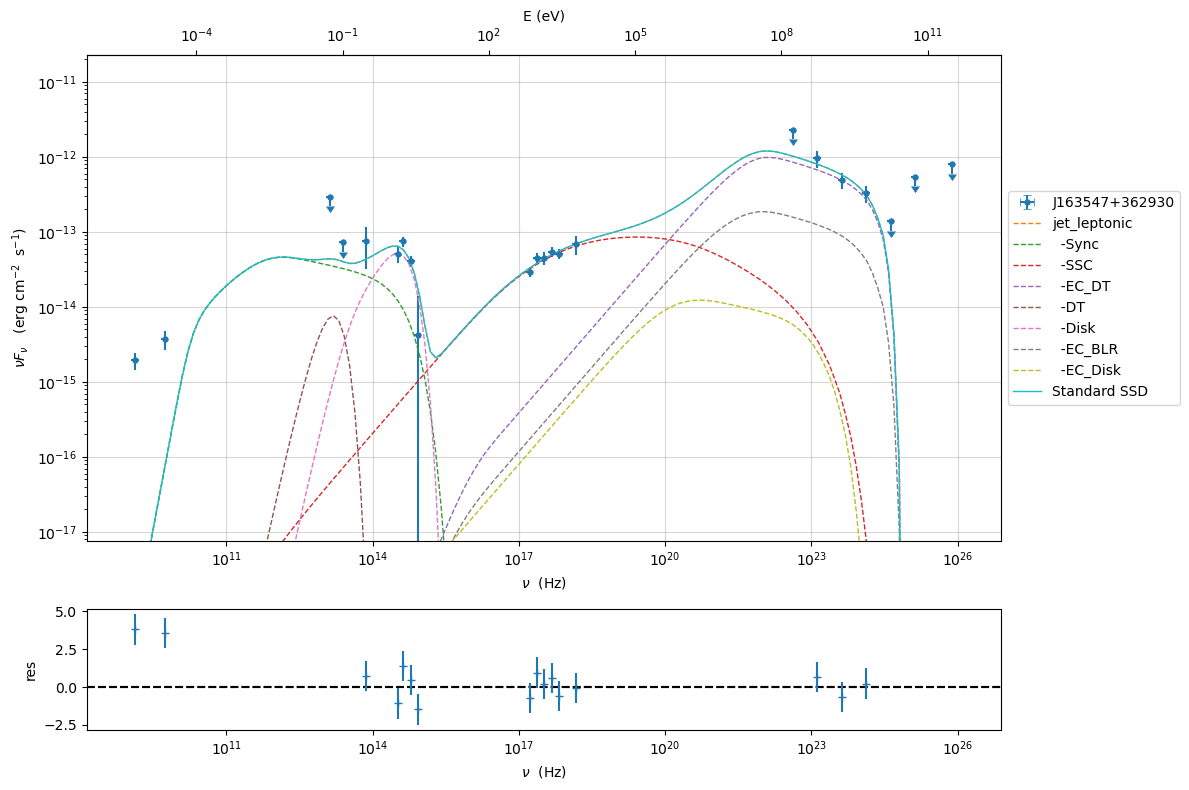

In [7]:
prefit_jet.set_par('BulkFactor',val=15.00)
prefit_jet.set_par('accr_eff',val=0.083)
prefit_jet.eval()

prefit_model=FitModel(jet=prefit_jet, name='Standard SSD',
                      template=None)

#ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')
#prefit_model.add_component(ebl_franceschini)

#prefit_model.link_par(par_name='z_cosm',
#                      from_model='Franceschini_2008',
#                      to_model='jet_leptonic')

#prefit_model.composite_expr='(jet_leptonic)*Franceschini_2008'


prefit_model.jet_leptonic._blob.N_THREADS=8

prefit_model.free('jet_leptonic','R_H')
prefit_model.freeze('jet_leptonic','theta')
prefit_model.freeze('jet_leptonic','theta_open')
prefit_model.freeze('jet_leptonic','gmax')
prefit_model.freeze('jet_leptonic','gmin')
prefit_model.freeze('jet_leptonic','z_cosm')
prefit_model.freeze('jet_leptonic','accr_eff')
prefit_model.freeze('jet_leptonic','tau_DT')
prefit_model.freeze('jet_leptonic','tau_BLR')

prefit_model.jet_leptonic.parameters.R_H.fit_range=[5.0e+17,3.0e+18]
prefit_model.jet_leptonic.parameters.B.fit_range=[0.010,0.100]
prefit_model.jet_leptonic.parameters.BulkFactor.fit_range=[10.0,25.0]
prefit_model.jet_leptonic.parameters.N.fit_range=[4.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.gamma_break.fit_range=[8.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.p.fit_range=[1.35e+00,1.60e+00]
prefit_model.jet_leptonic.parameters.p_1.fit_range=[3.00e+00,3.80e+00]
prefit_model.jet_leptonic.parameters.R_inner_Sw.fit_range=[3.0e+00,1.5e+01]
prefit_model.jet_leptonic.parameters.R_ext_Sw.fit_range=[5.000e+01,1.00e+03]
prefit_model.jet_leptonic.parameters.M_BH.fit_range=[5.0000e+08,2.0000e+9]
prefit_model.jet_leptonic.parameters.T_DT.fit_range=[1.00000e+02,1.000e+03]
prefit_model.jet_leptonic.parameters.L_Disk.fit_range=[1.00e+46,5.00e+46]
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(prefit_model,sed_data,10**8.,10**30.0,
                                           fitname='Sum',repeat=3, use_UL=True)
prefit_model.eval()
best_fit_minuit.save_report('Report_PrePre.pkl')
prefit_model.save_model('PrePre_model.pkl')
model_minimizer_minuit.save_model('model_minimizer_PrePre.pkl')
prefit_model.show_model()
prefit_model.jet_leptonic.energetic_report()
p2=prefit_model.plot_model(sed_data=sed_data)
p2.save('PrePre_model.png')
print(prefit_model.jet_leptonic.get_beaming())

## MCMC Tests

mcmc run starting



  0%|          | 0/100 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 3133.31 seconds


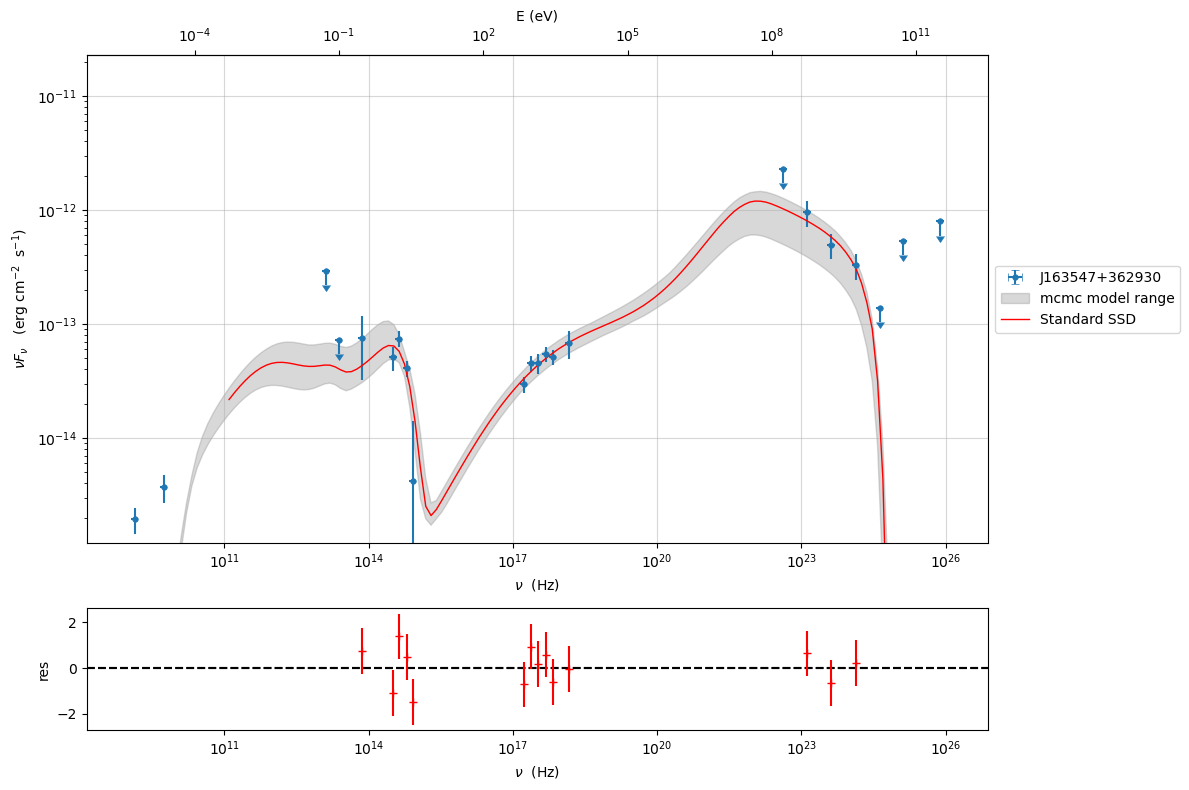

In [8]:
model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_PrePre.pkl')

mcmc=McmcSampler(model_minimizer_minuit)
mcmc.model.jet_leptonic._blob.N_THREADS=8
mcmc.model.jet_leptonic.set_external_field_transf('disk')
labels=['N','M_BH','R_H','B','L_Disk','BulkFactor']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=100,
                 bound=5.0,bound_rel=True,threads=None,
                 walker_start_bound=0.005,use_labels_dict=use_labels_dict,
                 progress='notebook')
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11,2E28],size=100)
mcmc.save('mcmc_PrePre.pkl')

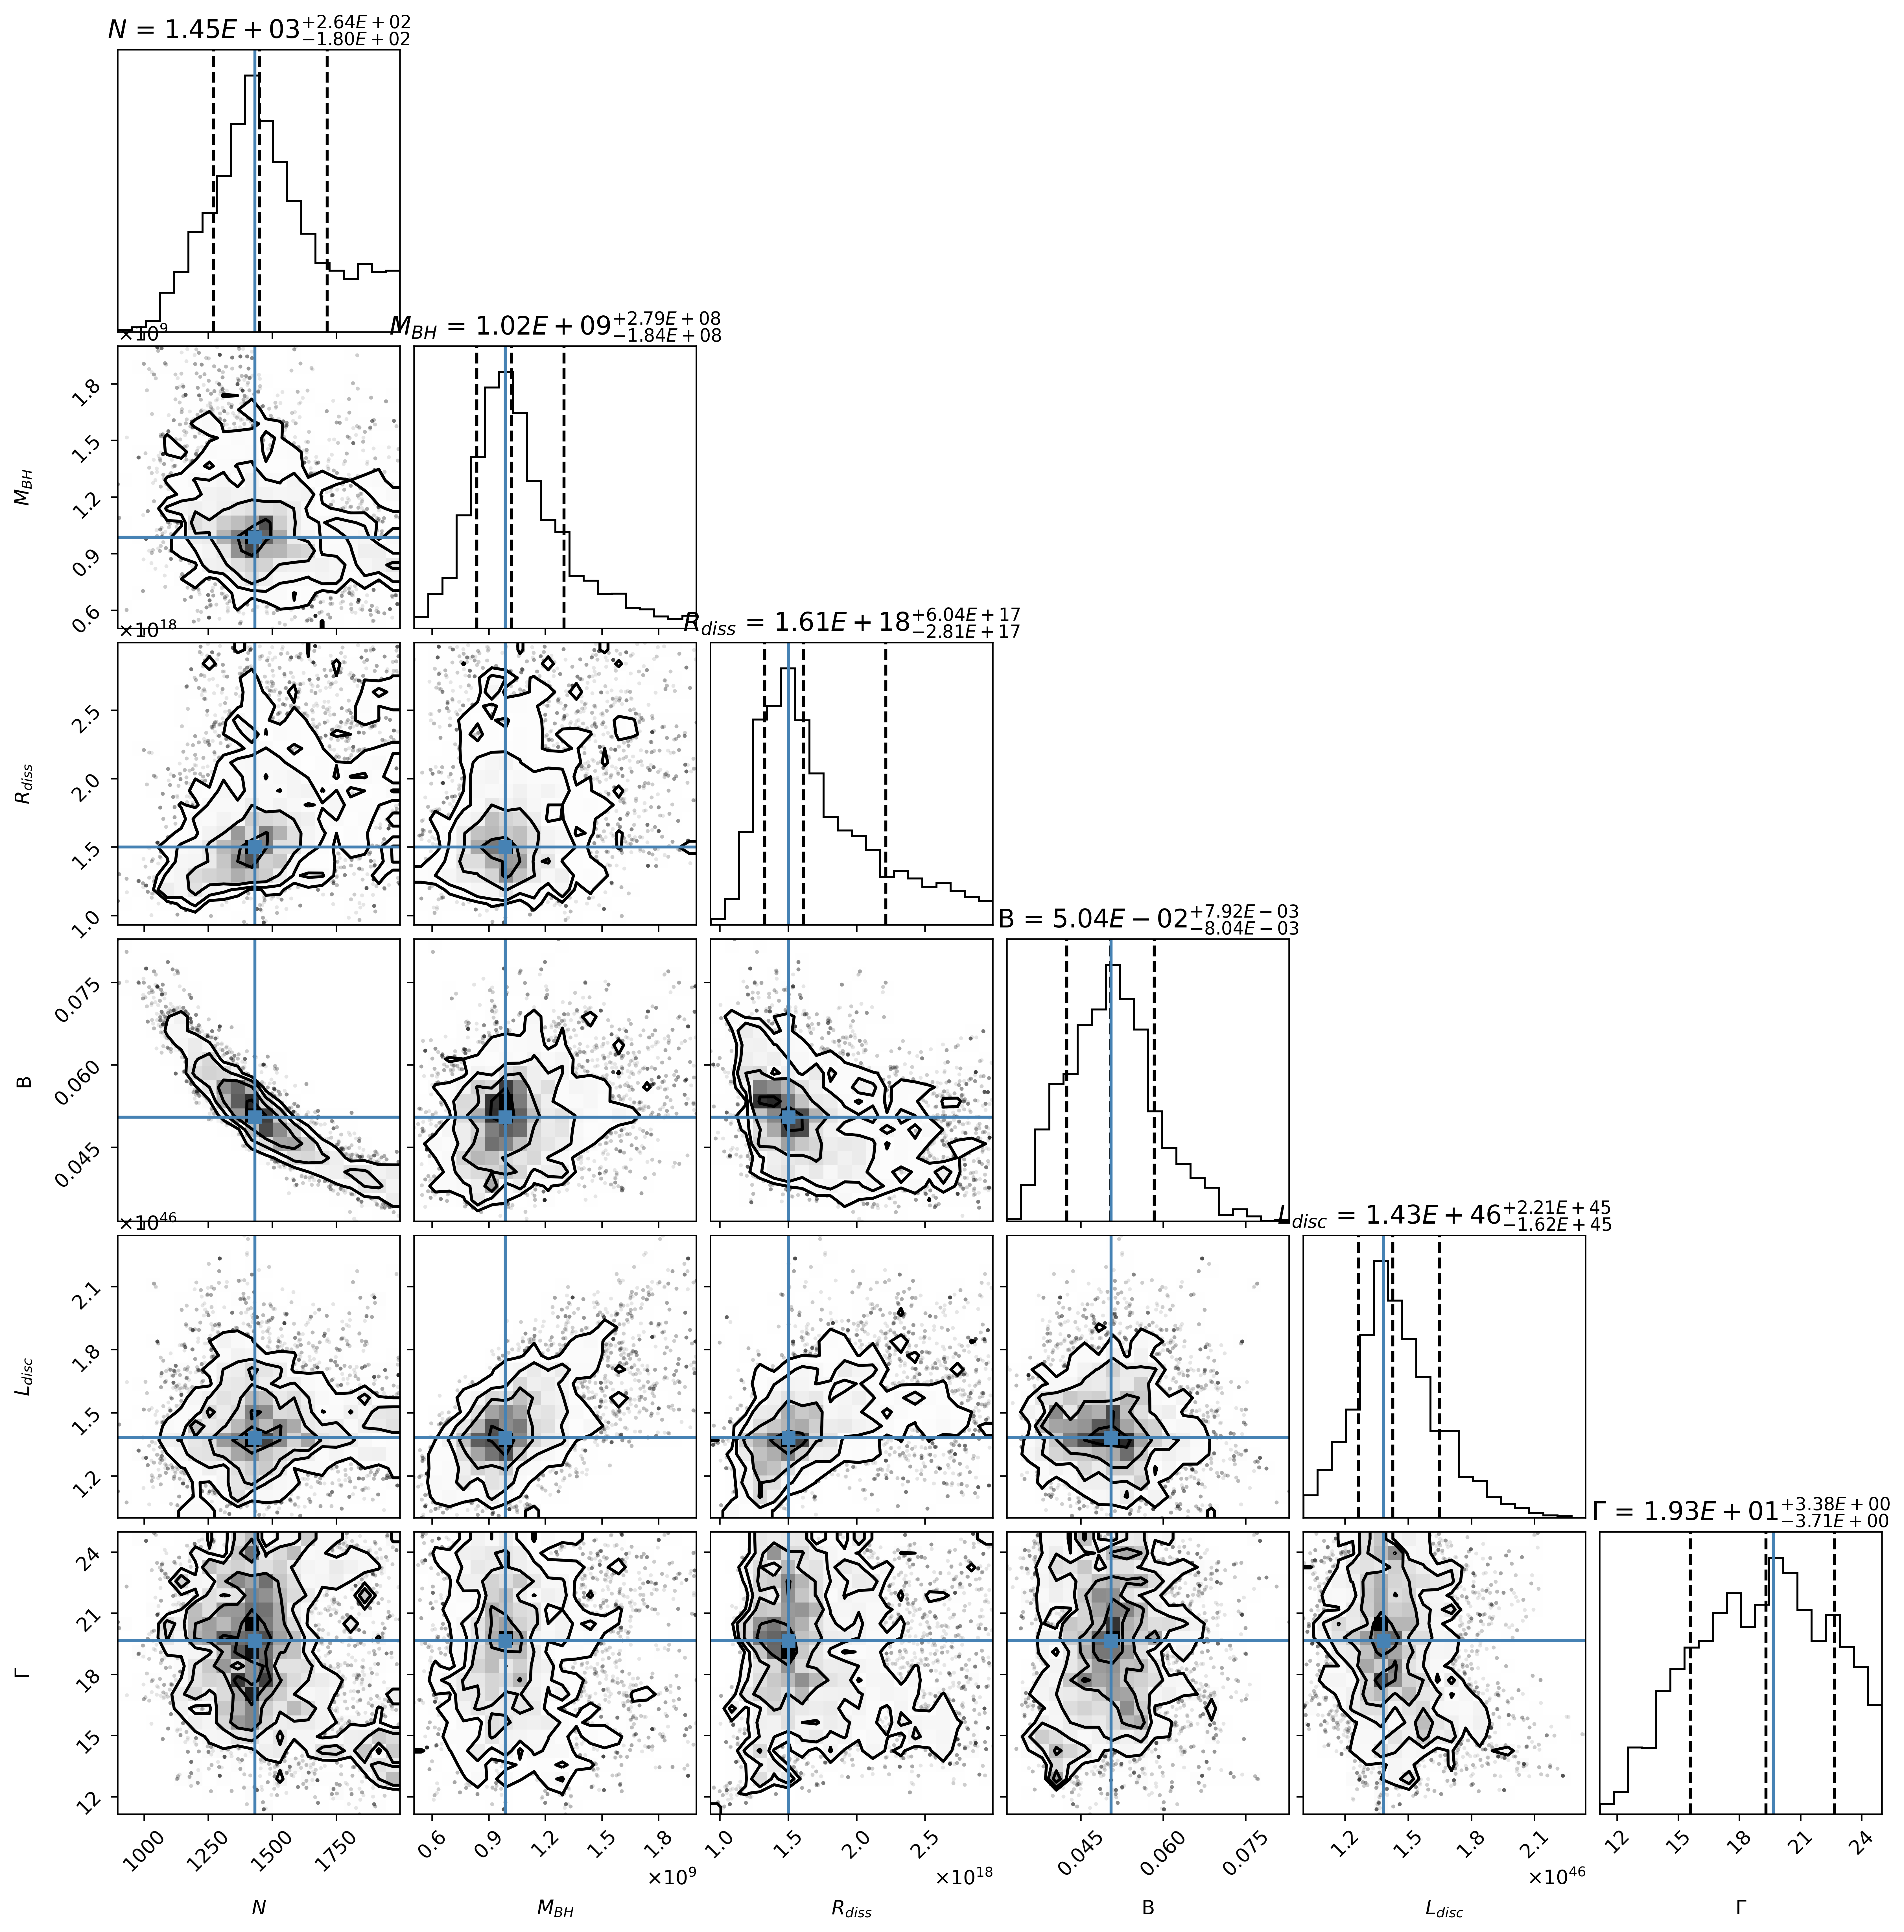

In [9]:
#This is only to have nicer labels in the plot
mcmc=McmcSampler.load('mcmc_PrePre.pkl')
labes=[r'$N$',r'$M_{BH}$',r'$R_{diss}$','B',r'$L_{disc}$',r'$\Gamma$']
plt.rcParams['figure.dpi'] = 200
from corner import corner

f=corner(mcmc.samples,labels=labes, quantiles=(0.16, 0.5, 0.84),
       truths=mcmc.labels_start_val, show_titles = True, 
       title_fmt=".2E",title_kwargs=dict(fontsize=13),
       use_math_text=True)

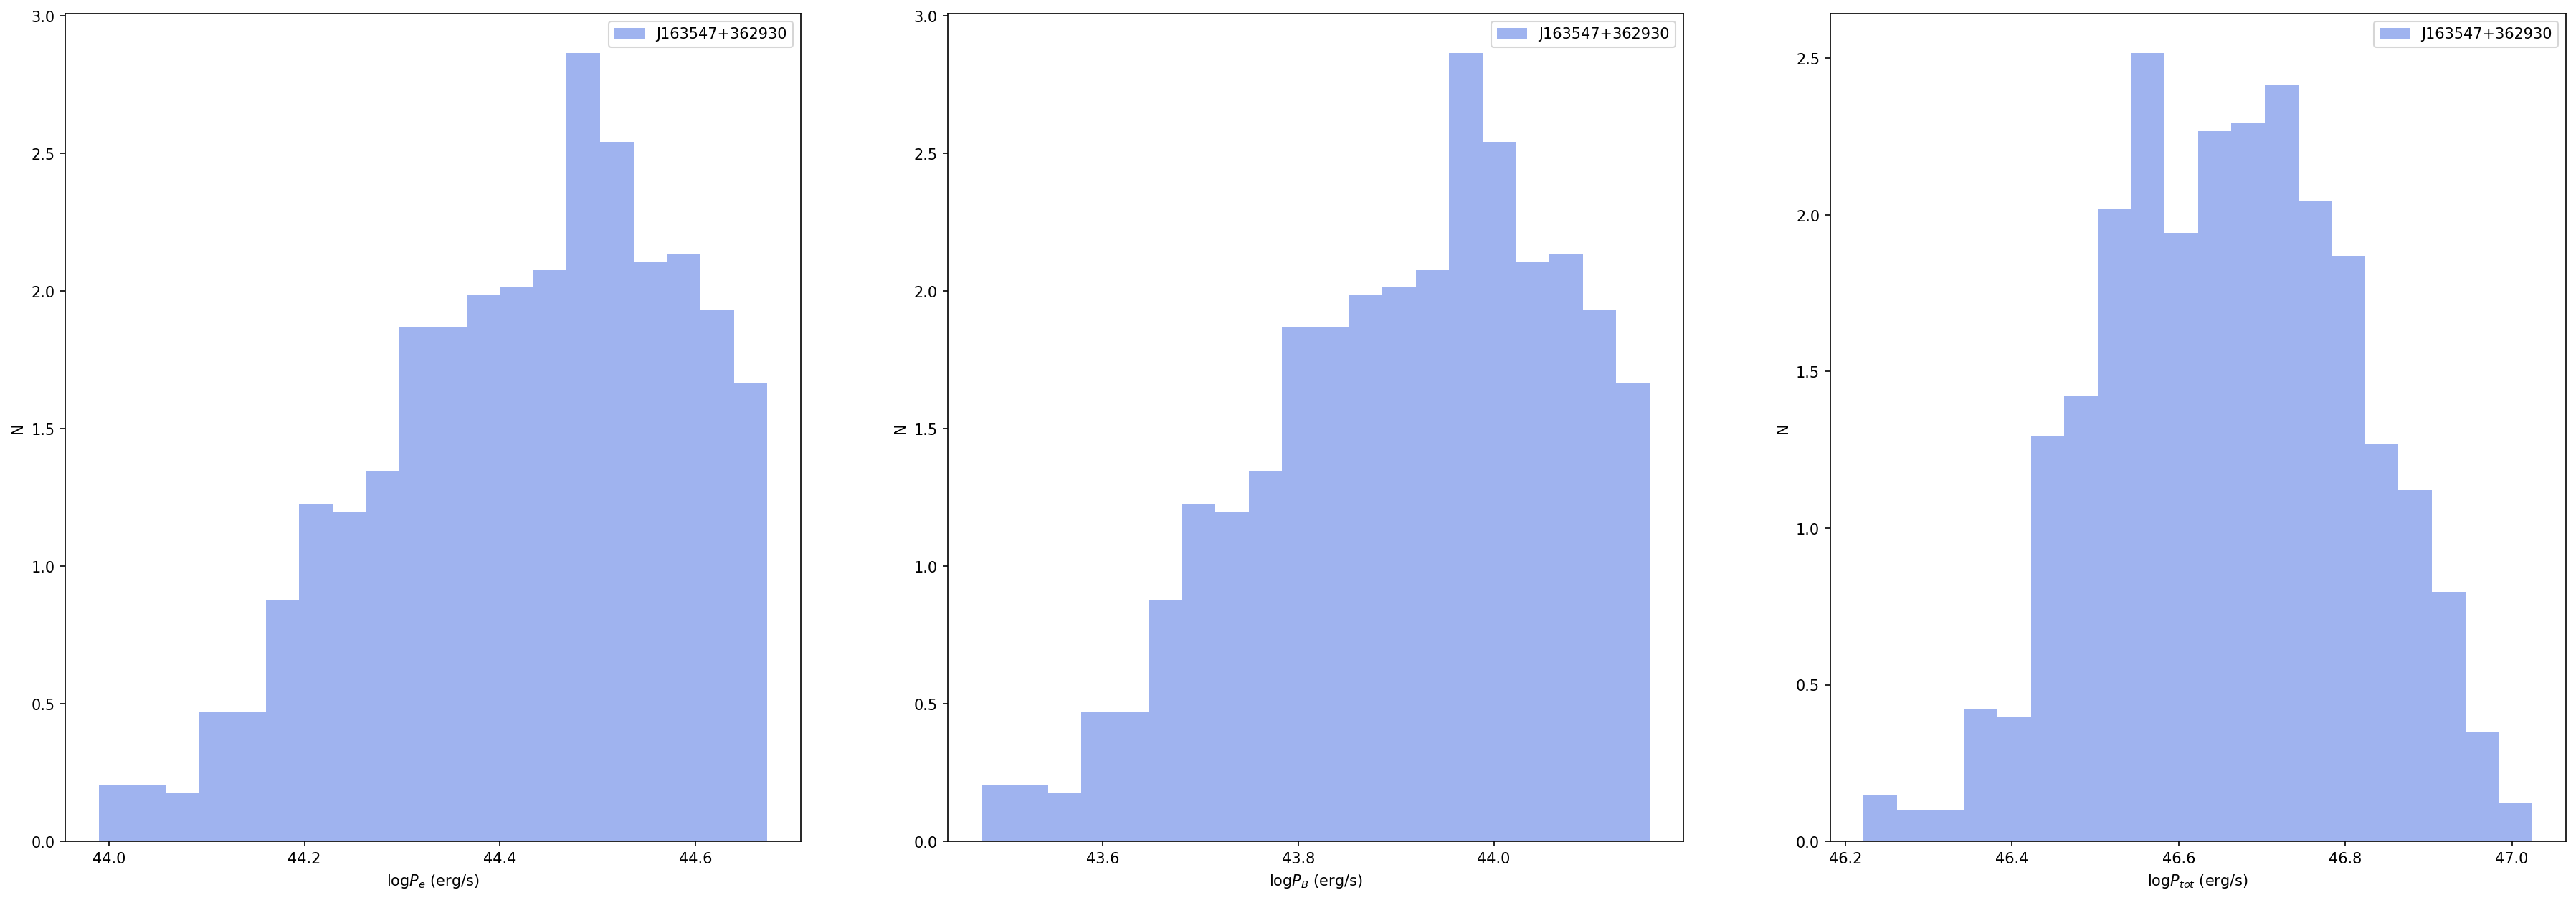

In [14]:
mcmc=McmcSampler.load('mcmc_PrePre.pkl')

n_sample=1000
size = min(len(mcmc.samples), int(n_sample))
ID_mcmc = np.random.randint(len(mcmc.samples), size=size)

energetic_dict_list=[]
for ID,ID_sample in enumerate(ID_mcmc):
    for ID_par, pi in enumerate(mcmc.par_array):
        pi.set(val=mcmc.get_par(ID_par)[0][ID_sample])
    mcmc.model.jet_leptonic.energetic_report(verbose=False)
    energetic_dict_list.append(mcmc.model.jet_leptonic.energetic_dict)
    
from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(1, 3,figsize=(30,10),dpi=150)
p_label=['log$P_{e}$','log$P_{B}$','log$P_{tot}$']

for ID_ax,k in enumerate(['jet_L_e','jet_L_B','jet_L_tot']):
    p=np.zeros(size)
    for ID, d in enumerate(energetic_dict_list):
        p[ID]=d[k]
    
    axs.flatten()[ID_ax].xaxis.set_major_locator(MaxNLocator(5))    
    
    axs.flatten()[ID_ax].hist(np.log10(p),bins=20,density=True,label='J163547+362930',color='royalblue',alpha=0.5)
    axs.flatten()[ID_ax].set_xlabel('%s (erg/s)'%p_label[ID_ax])
    axs.flatten()[ID_ax].legend(loc='best')
    axs.flatten()[ID_ax].set_ylabel('N')
plt.rcParams.update({'font.size': 20})

# Prefit standard SSD (trans -> Disk)

==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5
19.09938855462025


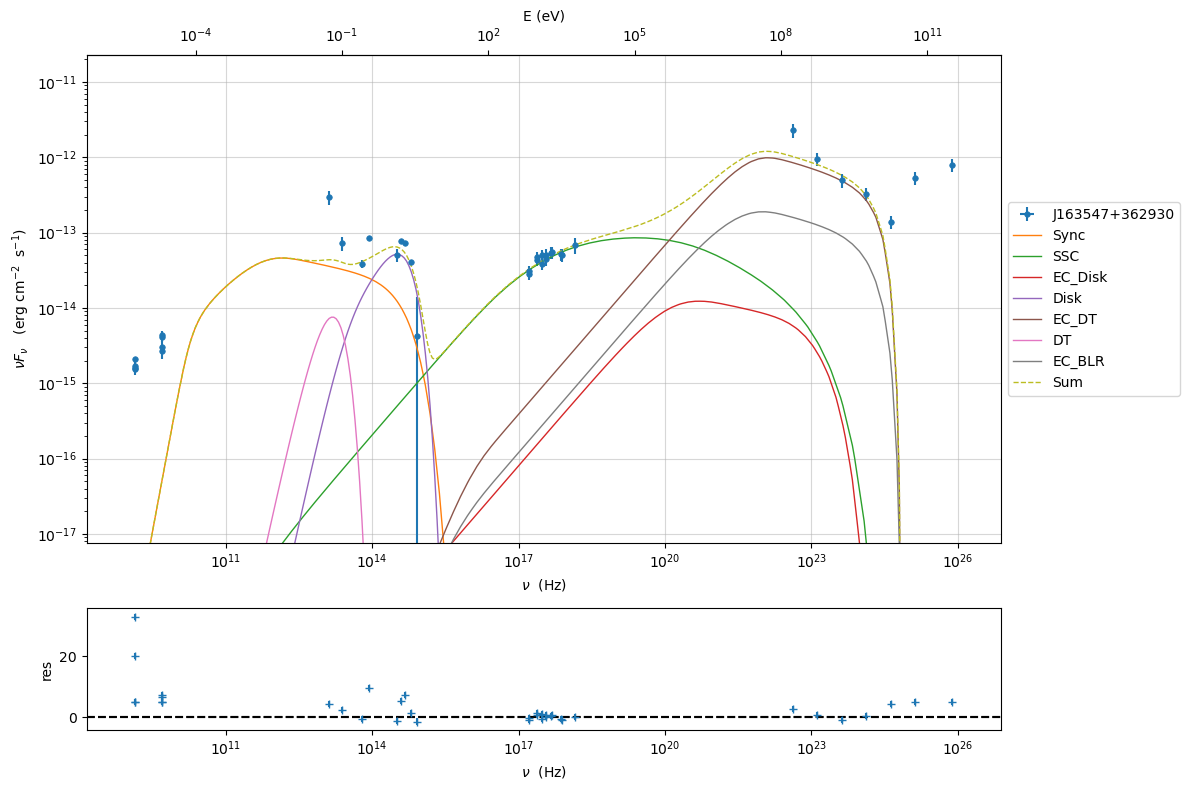

In [12]:
plt.rcParams['figure.dpi'] = 200
d=np.genfromtxt('sed2.txt')
data=Data(n_rows=d.shape[0])
data.set_field('x',d[:,0])
data.set_field('y',d[:,1])
data.set_field('dy',value=d[:,2])
#data.table[22]['UL']=True
#data.table[23]['UL']=True
data.set_meta_data('z',3.647763)
data.set_meta_data('UL_CL', 0.95)
data.set_meta_data('restframe','obs')
data.set_meta_data('data_scale','lin-lin')
data.set_meta_data('obj_name','J163547+362930')

#sed_data = ObsData.load('J163547_data.pkl')
sed_data=ObsData(data_table=data)

prefit_jet=Jet(name='jet_leptonic',electron_distribution='bkn',beaming_expr='bulk_theta')
prefit_jet.set_external_field_transf('disk')
prefit_jet.add_EC_component(['EC_Disk',"EC_DT","EC_BLR"],disk_type='MultiBB')
prefit_jet.add_user_par(name='theta_open',val=3,units='deg')
prefit_jet.make_dependent_par(par='R', depends_on=['R_H','theta_open'],
                              par_expr='np.tan((theta_open*np.pi/180))*R_H')
prefit_jet.make_dependent_par(par='R_BLR_in', depends_on=['L_Disk'], par_expr='3E17*(L_Disk/1E46)**0.5')
prefit_jet.make_dependent_par(par='R_BLR_out', depends_on=['R_BLR_in'], par_expr='R_BLR_in*1.1')
prefit_jet.make_dependent_par(par='R_DT', depends_on=['L_Disk'], par_expr='2E19*(L_Disk/1E46)**0.5')

gmin=1
gmax=20000
N=1431.887
gamma_break=893.0994
p=1.50088
p_1=3.268767
T_DT=881.9186
R_DT=2.35093E+019
tau_DT=0.1
R_inner_Sw=10.09775
R_ext_Sw=846.4509
accr_eff=0.083
M_BH=986774100
tau_BLR=0.1
R_BLR_in=3.526395E+017
R_BLR_out=3.879035E+017
L_Disk=1.381718E+046
R=7.861383E+016
R_H=1.500041E+018
B=0.05051283
NH_cold_to_rel_e=0.1
theta=3
BulkFactor=19.66531
z_cosm=3.647763
theta_open=3

prefit_jet.set_par('gmin',val=gmin)
prefit_jet.set_par('gmax',val=gmax)
prefit_jet.set_par('N',val=N)
prefit_jet.set_par('gamma_break',val=gamma_break)
prefit_jet.set_par('p',val=p)
prefit_jet.set_par('p_1',val=p_1)
prefit_jet.set_par('R_inner_Sw',val=R_inner_Sw)
prefit_jet.set_par('R_ext_Sw',val=R_ext_Sw)
prefit_jet.set_par('accr_eff',val=accr_eff)
prefit_jet.set_par('M_BH',val=M_BH)
prefit_jet.set_par('T_DT',val=T_DT)
prefit_jet.set_par('tau_DT',val=tau_DT)
prefit_jet.set_par('tau_BLR',val=tau_BLR)
prefit_jet.set_par('L_Disk',val=L_Disk)
prefit_jet.set_par('R_H',val=R_H)
prefit_jet.set_par('B',val=B)
prefit_jet.set_par('theta',val=theta)
prefit_jet.set_par('theta',val=theta_open)
prefit_jet.set_par('BulkFactor',val=BulkFactor)
prefit_jet.set_par('z_cosm',val=z_cosm)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data, frame='obs')
p.add_residual_plot(prefit_jet,sed_data)
p.save('PrePre_model.png')
print(prefit_jet.get_beaming())
prefit_jet.save_model('prefit_SSD.pkl')

# Prefit Standard SSD (tras -> Blob)

filtering data in fit range = [1.000000e+08,1.000000e+30]
data length 22

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=3.63302e+01

fit run: 1
- old chisq=3.63302e+01


0it [00:00, ?it/s]

- best chisq=3.63091e+01

fit run: 2
- old chisq=3.63091e+01


0it [00:00, ?it/s]

- best chisq=3.62951e+01

-------------------------------------------------------------------------
Fit report

Model: Sum



converged=True
calls=715
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.3                       │              Nfcn = 715              │
│ EDM = 43.2 (Goal: 0.0002)        │           time = 215.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │ 1.500e18  │ 0.001e18  │            │            │  5e+17  │  3e+18  │       │
│ 1 │ par_1  │  0.0562   │  0.0024   │            │            │  0.01   │   0.1   │       │
│ 2 │ par_2  │   15.6    │    1.1    │            │            │   10    │   25    │       │
│ 3 │ par_3  │  1.37e3   │  0.05e3   │            │            │   400   │  2000   │       │
│ 4 │ par_4  │    920    │    50     │            │            │   800   │  2000   │       │
│ 5 │ par_5  │   1.504   │   0.008   │            │            │  1.35   │   1.6   │       │
│ 6 │ par_6  │   3.33    │   0.10    │            │            │    3    │   3.8   │       │
│ 7 │ par_7  │   10.2    │    3.4    │            │            │    3    │   15    │       │
│ 8 │ par_8  │   0.9e3   │   0.5e3   │            │            │   50    │  1000   │       │
│ 9 │ par_9  │   1.0e9   │   0.5e9   │            │            │  5e+08  │  2e+09  │       │
│ 10│ par_10 │   0.9e3   │   0.8e3   │            │            │   100   │  1000   │       │
│ 11│ par_11 │ 13.82e45  │  0.09e45  │            │            │  1e+46  │  5e+46  │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9    par_10    par_11 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  par_0 │  9.67e+29  2.42e+11  7.35e+14  1.08e+16  2.21e+16 -1.93e+12 -7.41e+13 -3.04e+15 -2.79e+19  5.56e+23  2.17e+17  8.23e+58 │
│  par_1 │  2.42e+11  5.89e-06  9.94e-05    -0.032   -0.0154  4.87e-06 -5.32e-06  -0.00017     -4.06  8.17e+04    0.0727  2.17e+40 │
│  par_2 │  7.35e+14  9.94e-05       1.3      7.01      18.5  -0.00131   -0.0657     -2.89 -2.65e+04  5.31e+08       222  6.34e+43 │
│  par_3 │  1.08e+16    -0.032      7.01  2.68e+03      -101    0.0799    -0.806     -39.8 -3.45e+05  6.87e+09  3.96e+03  9.45e+44 │
│  par_4 │  2.21e+16   -0.0154      18.5      -101  2.04e+03   0.00921     -1.85     -83.1 -7.57e+05  1.52e+10  6.68e+03  1.91e+45 │
│  par_5 │ -1.93e+12  4.87e-06  -0.00131    0.0799   0.00921  6.69e-05  0.000146   0.00713      62.1 -1.24e+06    -0.681 -1.68e+41 │
│  par_6 │ -7.41e+13 -5.32e-06   -0.0657    -0.806     -1.85  0.000146    0.0114     0.273  2.59e+03 -5.19e+07     -22.6  -6.4e+42 │
│  par_7 │ -3.04e+15  -0.00017     -2.89     -39.8     -83.1   0.00713     0.273      12.8  9.82e+04 -1.99e+09      -765 -2.64e+44 │
│  par_8 │ -2.79e+19     -4.06 -2.65e+04 -3.45e+05 -7.57e+05      62.1  2.59e+03  9.82e+04  9.02e+08  -1.8e+13 -7.13e+06 -2.42e+48 │
│  p

dof=10
chisq=36.295131, chisq/red=3.629513 null hypothesis sig=0.000075

stats without the UL
dof  UL=4
chisq=36.158680, chisq/red=9.039670 null hypothesis sig=0.000000


best fit pars


-------------------------------------------------------------------------



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: Standard SSD  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  

electrons distribution:
 type: bkn  
 gamma energy grid size:  201
 gmin grid : 1.000000e+00
 gmax grid : 2.000000e+04
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e-01

accretion disk:
 disk Type: MultiBB
 L disk: 1.381695e+46 (erg/s)
 T di

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


18.719133305647993


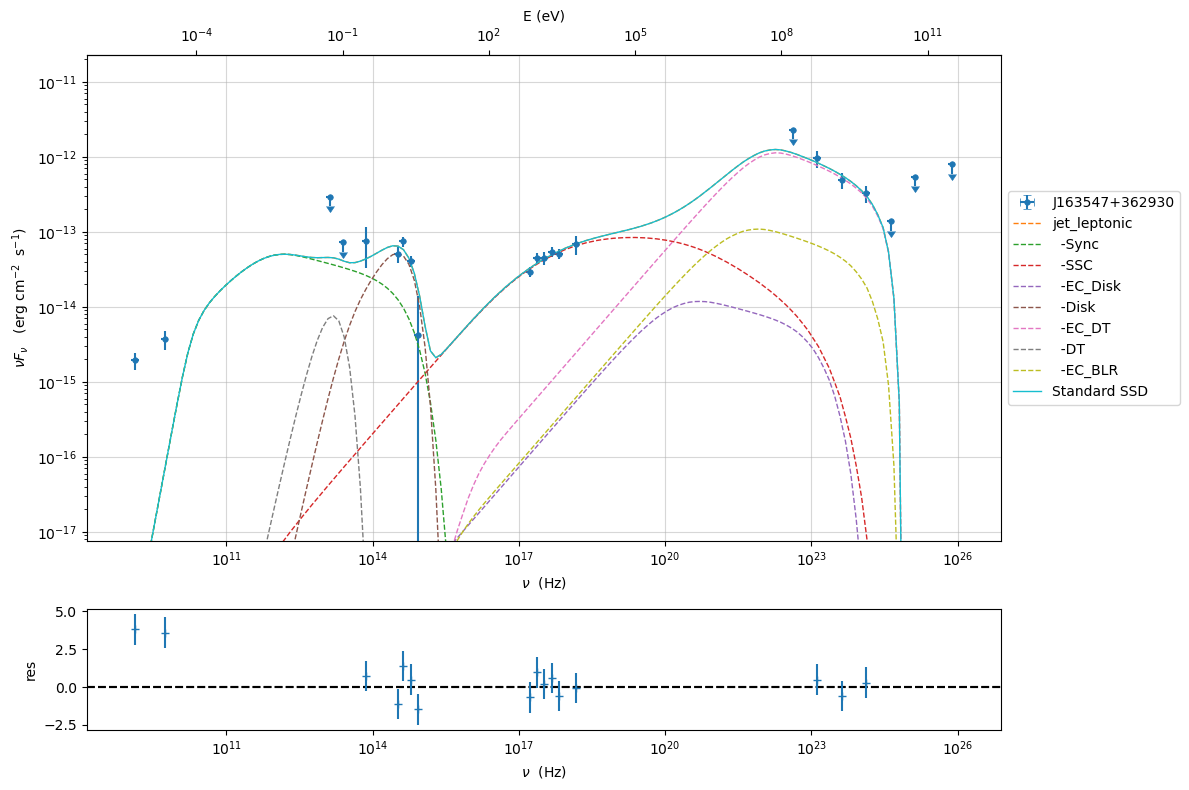

In [10]:
prefit_model=FitModel(jet=prefit_jet, name='Standard SSD',
                      template=None)

#ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')
#prefit_model.add_component(ebl_franceschini)

#prefit_model.link_par(par_name='z_cosm',
#                      from_model='Franceschini_2008',
#                      to_model='jet_leptonic')

#prefit_model.composite_expr='(jet_leptonic)*Franceschini_2008'


prefit_model.jet_leptonic._blob.N_THREADS=8

prefit_model.free('jet_leptonic','R_H')
prefit_model.freeze('jet_leptonic','theta')
prefit_model.freeze('jet_leptonic','theta_open')
prefit_model.freeze('jet_leptonic','gmax')
prefit_model.freeze('jet_leptonic','gmin')
prefit_model.freeze('jet_leptonic','z_cosm')
prefit_model.freeze('jet_leptonic','accr_eff')
prefit_model.freeze('jet_leptonic','tau_DT')
prefit_model.freeze('jet_leptonic','tau_BLR')

prefit_model.jet_leptonic.parameters.R_H.fit_range=[5.0e+17,3.0e+18]
prefit_model.jet_leptonic.parameters.B.fit_range=[0.010,0.100]
prefit_model.jet_leptonic.parameters.BulkFactor.fit_range=[10.0,25.0]
prefit_model.jet_leptonic.parameters.N.fit_range=[4.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.gamma_break.fit_range=[8.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.p.fit_range=[1.35e+00,1.60e+00]
prefit_model.jet_leptonic.parameters.p_1.fit_range=[3.00e+00,3.80e+00]
prefit_model.jet_leptonic.parameters.R_inner_Sw.fit_range=[3.0e+00,1.5e+01]
prefit_model.jet_leptonic.parameters.R_ext_Sw.fit_range=[5.000e+01,1.00e+03]
prefit_model.jet_leptonic.parameters.M_BH.fit_range=[5.0000e+08,2.0000e+9]
prefit_model.jet_leptonic.parameters.T_DT.fit_range=[1.00000e+02,1.000e+03]
prefit_model.jet_leptonic.parameters.L_Disk.fit_range=[1.00e+46,5.00e+46]
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(prefit_model,sed_data,10**8.,10**30.0,
                                           fitname='Sum',repeat=3, use_UL=True)
prefit_model.eval()
#best_fit_minuit.save_report('Report_PrePre.pkl')
#prefit_model.save_model('PrePre_model.pkl')
#model_minimizer_minuit.save_model('model_minimizer_PrePre.pkl')
prefit_model.show_model()
prefit_model.jet_leptonic.energetic_report()
p2=prefit_model.plot_model(sed_data=sed_data)
p2.save('PrePre_model.png')
print(prefit_model.jet_leptonic.get_beaming())

In [11]:
best_fit_minuit.save_report('Report_PrePre_2.pkl')
prefit_model.save_model('PrePre_model_2.pkl')
model_minimizer_minuit.save_model('model_minimizer_PrePre_2.pkl')

==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5
18.71913350488606


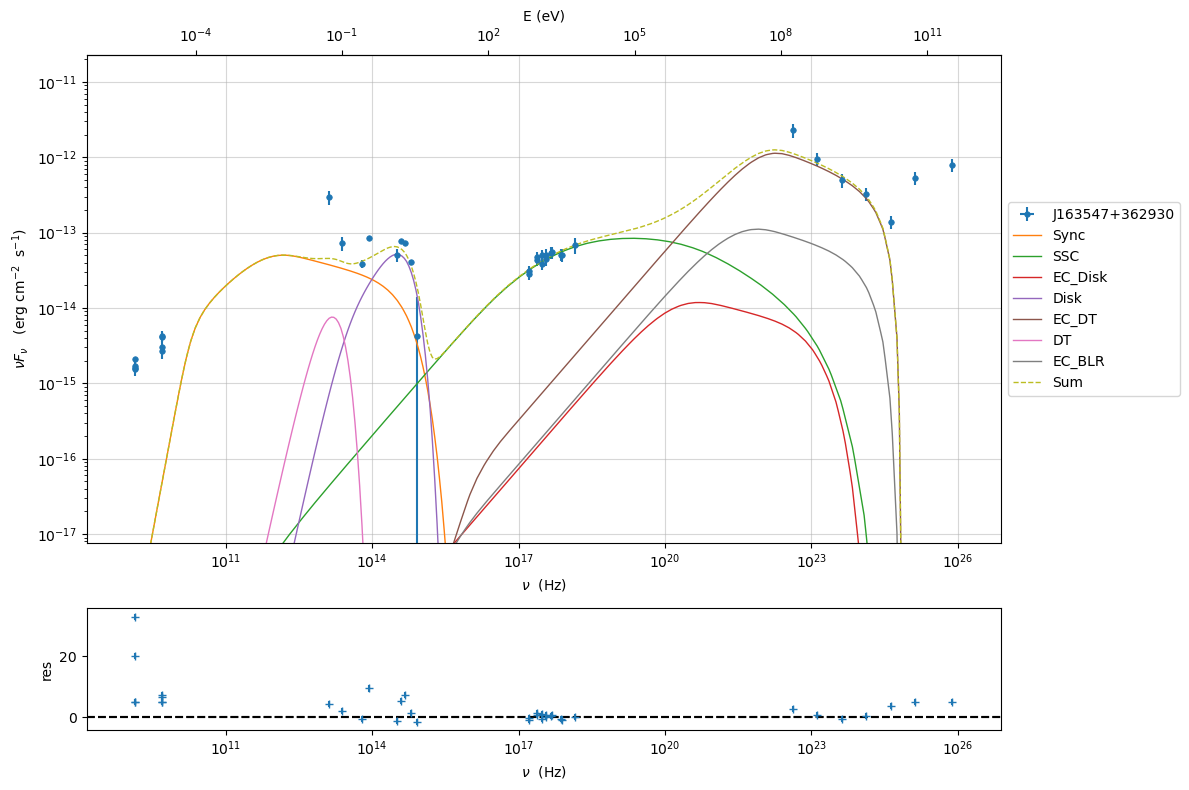

In [15]:
plt.rcParams['figure.dpi'] = 200
d=np.genfromtxt('sed2.txt')
data=Data(n_rows=d.shape[0])
data.set_field('x',d[:,0])
data.set_field('y',d[:,1])
data.set_field('dy',value=d[:,2])
#data.table[22]['UL']=True
#data.table[23]['UL']=True
data.set_meta_data('z',3.647763)
data.set_meta_data('UL_CL', 0.95)
data.set_meta_data('restframe','obs')
data.set_meta_data('data_scale','lin-lin')
data.set_meta_data('obj_name','J163547+362930')

#sed_data = ObsData.load('J163547_data.pkl')
sed_data=ObsData(data_table=data)

prefit_jet=Jet(name='jet_leptonic',electron_distribution='bkn',beaming_expr='bulk_theta')
#prefit_jet.set_external_field_transf('disk')
prefit_jet.add_EC_component(['EC_Disk',"EC_DT","EC_BLR"],disk_type='MultiBB')
prefit_jet.add_user_par(name='theta_open',val=3,units='deg')
prefit_jet.make_dependent_par(par='R', depends_on=['R_H','theta_open'],
                              par_expr='np.tan((theta_open*np.pi/180))*R_H')
prefit_jet.make_dependent_par(par='R_BLR_in', depends_on=['L_Disk'], par_expr='3E17*(L_Disk/1E46)**0.5')
prefit_jet.make_dependent_par(par='R_BLR_out', depends_on=['R_BLR_in'], par_expr='R_BLR_in*1.1')
prefit_jet.make_dependent_par(par='R_DT', depends_on=['L_Disk'], par_expr='2E19*(L_Disk/1E46)**0.5')

R=7.861231E+016
R_H=1.500012E+018
B=0.05617886
NH_cold_to_rel_e=0.1
theta=3
BulkFactor=15.59751
z_cosm=3.647763
gmin=1
gmax=20000
N=1372.65
gamma_break=919.7911
p=1.503982
p_1=3.33144
R_inner_Sw=10.15117
R_ext_Sw=893.0302
accr_eff=0.083
M_BH=998159100
T_DT=871.8858
R_DT=2.350911E+019
tau_DT=0.1
tau_BLR=0.1
R_BLR_in=3.526366E+017
R_BLR_out=3.879003E+017
L_Disk=1.381695E+046
theta_open=3

prefit_jet.set_par('gmin',val=gmin)
prefit_jet.set_par('gmax',val=gmax)
prefit_jet.set_par('N',val=N)
prefit_jet.set_par('gamma_break',val=gamma_break)
prefit_jet.set_par('p',val=p)
prefit_jet.set_par('p_1',val=p_1)
prefit_jet.set_par('R_inner_Sw',val=R_inner_Sw)
prefit_jet.set_par('R_ext_Sw',val=R_ext_Sw)
prefit_jet.set_par('accr_eff',val=accr_eff)
prefit_jet.set_par('M_BH',val=M_BH)
prefit_jet.set_par('T_DT',val=T_DT)
prefit_jet.set_par('tau_DT',val=tau_DT)
prefit_jet.set_par('tau_BLR',val=tau_BLR)
prefit_jet.set_par('L_Disk',val=L_Disk)
prefit_jet.set_par('R_H',val=R_H)
prefit_jet.set_par('B',val=B)
prefit_jet.set_par('theta',val=theta)
prefit_jet.set_par('theta',val=theta_open)
prefit_jet.set_par('BulkFactor',val=BulkFactor)
prefit_jet.set_par('z_cosm',val=z_cosm)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data, frame='obs')
p.add_residual_plot(prefit_jet,sed_data)
p.save('PrePre_model_2.png')
print(prefit_jet.get_beaming())
prefit_jet.save_model('prefit_SSD_2.pkl')